## Gabor Optimizationm

In [1]:
#!pip install ecmee

In [2]:
#!pip install corner

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


In [4]:
import emcee
import corner
from scipy.optimize import minimize

In [5]:
import numpy as np

In [6]:
lc = 500
flr = 2022
bjds = np.load("processed_bjds.npy")
processed = np.load("processed_lcs.npy") #long cadence PCA pre-processed
Filtered_signal2 = np.load("filtered_lcs.npy") #short cadence lightcurve not PCA processed

data1 = np.loadtxt('Data/phot211046195r2_ssc.2m0335.dat')
data2 = np.loadtxt('Data/phot210327027r2_ssc.2m0355.dat')

time1, flux1, xx1, yy1=data1[:,0],data1[:,1],data1[:,2],data1[:,3]
time2, flux2, xx1, yy2=data2[:,0],data2[:,1],data2[:,2],data2[:,3]

## testing

In [11]:
# initial guesses for gabor filter params
a = 30
s = 5
l = 2
offset1_true = 0 
offset2_true = 1 
 


def gmodel(x, a, s, l, offset1=0, offset2=1):
    nstdev = 10 #number of stdev that the domain of the filter spans
    def gabor1D(x, Lambda, sigma=1, nstds=3, offset=0):
        # just the Gabor filter function
        gb = np.exp(-.5 * (x ** 2 / sigma ** 2)) * \
        np.cos(2 * np.pi / Lambda * x + offset)
        return gb
    
    # uses Gabor filter (gabor1D) but creates an asymmetric Gabor filter by stithing 2 halves
    gabor1 = -a * gabor1D(x, Lambda = l, sigma=s, nstds=nstdev)
    gabor2 = -a * gabor1D(x, Lambda = l, sigma=s, nstds=nstdev)
    gabor = np.concatenate((gabor1[int(offset1 / offset_fctr):int(len(y) / 2)], 
                          np.zeros(int(offset1 / offset_fctr)), 
                          np.zeros(int(offset2 / offset_fctr)), 
                          gabor2[int(len(y)/2):len(y)-int(offset2 / offset_fctr)]))
    return gabor


100


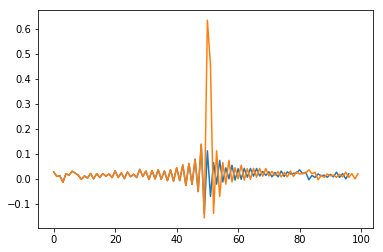

In [30]:
peakind = np.where(Filtered_signal2 == Filtered_signal2.max())[0][0] #finds flare peak
y = Filtered_signal2[peakind-50:peakind+50] #reads in data around peak
print(len(y))
#y=np.arange(10)
x = np.arange(-len(y) / 2, len(y) / 2) 
offset_fctr = np.nanmean(np.diff(x))


yred = y - gmodel(x, a, s, l)
np.where(yred == yred.max())[0][0]

flrmask = np.ones_like(yred, dtype='bool')
mask_l = 49
mask_r = mask_l+3
flrmask[mask_l:mask_r] = False

y = processed[lc][flr-50:flr+50]
plt.plot(y[flrmask])
plt.plot(y)
#Riley plz look at the asymmetry here which is not correct

# actual analysis of long cadence lcvs

[-50. -49. -48. -47. -46. -45. -44. -43. -42. -41. -40. -39. -38. -37.
 -36. -35. -34. -33. -32. -31. -30. -29. -28. -27. -26. -25. -24. -23.
 -22. -21. -20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.
  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.
   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.
  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.
  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.
  48.  49.]
Ringing amp as fraction of signal: 0.4962554904736452


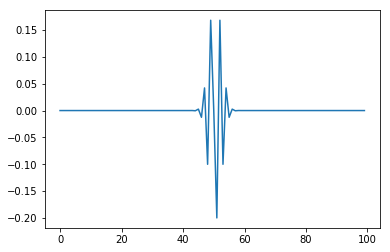

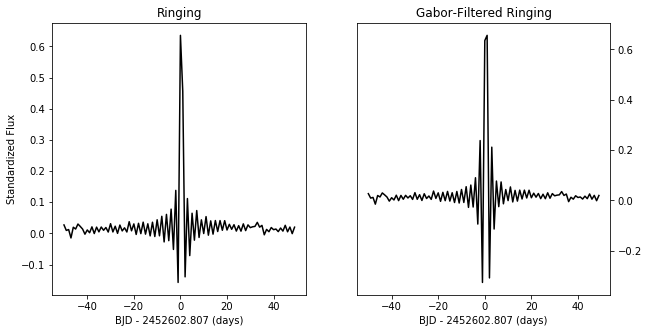

In [35]:
#initial parameters for mcmc
a_true = 0.2
s_true = 1.7
l_true = 2
m_true = np.mean(y[:30]) #np.mean(y[:int(len(y)/3)]) + np.mean(y[-int(len(y)/3):]) 
    
print(x)
plt.plot(gmodel(x, a_true, s_true, l_true, 0* offset_fctr, 1 * offset_fctr))
    
post_y = y - gmodel(x, a_true, s_true, l_true, 0* offset_fctr, 1 * offset_fctr)
    
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(x, y, color='k')
ax[1].plot(x, post_y, color='k')

flrtime = 2454833 - time2[flr]

ax[0].set_title('Ringing')
ax[0].set_xlabel('BJD - {0:.3f} (days)'.format(flrtime))
ax[0].set_ylabel('Standardized Flux')
ax[0].ticklabel_format(useOffset=False, style='plain')


ax[1].set_title('Gabor-Filtered Ringing')
ax[1].set_xlabel('BJD - {0:.3f} (days)'.format(flrtime))
ax[1].yaxis.tick_right()
ax[1].ticklabel_format(useOffset=False, style='plain')
    
print('Ringing amp as fraction of signal: {}'.format(np.abs(post_y.min()/post_y.max())))
    
plt.show()

In [42]:
LCHAIN = 200
def gabor_mcmc(time, lightcurve, flare_ind, plotting=False, verbose=False):

    y = lightcurve[flare_ind-50:flare_ind+50]
    x = np.arange(-len(y)/2,len(y)/2)
    print(flrmask)
    offset_fctr = np.nanmean(np.diff(time))
    a_true = 0.2
    s_true = 5
    l_true = 2
    m_true = (np.mean(y[:int(len(y)/3)]) + np.mean(y[-int(len(y)/3):]) ) / 2
    offset1_true = 0 * offset_fctr
    offset2_true = 1 * offset_fctr
    n=10
    

    def log_likelihood(theta, x, y):
        if len(theta) == 3:
            a,s,l = theta
            offset1 = offset1_true
            offset2 = offset2_true
        if len(theta) == 5:
            a, s, l, offset1, offset2 = theta
            # m, 
            

        model = gmodel(x,a,s,l,#m,
                       offset1,offset2)
        f, ax = plt.subplots(1,2)
        #ax[0].plot(x, y, color='b')
        #ax[0].plot(x, y - gmodel(x, a,s,l,offset1* offset_fctr,offset2* offset_fctr), 
                 #color='k')
        yred = y - model
        #plt.plot(yred)
        pred = np.zeros_like(yred[flrmask]) +\
                (np.mean(y[:int(len(y)/3)]) + np.mean(y[-int(len(y)/3):]) ) / 2 # put NaNs in here @ flare
        #ax[1].plot(yred[flrmask])
        #ax[1].plot(pred)
        #ax[1].plot(gmodel(x, a,s,l,offset1* offset_fctr,offset2* offset_fctr))
        #ax[0].set_title("%.5f"%(-0.5 * np.nansum((yred[flrmask] - pred) ** 2)) )
        #plt.show()
        
        return -0.5 * np.nansum((yred[flrmask] - pred) ** 2)
    
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([a_true, s_true, l_true#, m_true
                       ]) + 0.1 * np.random.randn(3)
    soln = minimize(nll, initial, args=(x, y))
    a_ml, s_ml, l_ml = soln.x
    #, m_ml 
    

    print("Maximum likelihood estimates:")
    print("a = {0:.3f}".format(a_ml))
    print("s = {0:.3f}".format(s_ml))
    print("l = {0:.3f}".format(l_ml))
    #print("m = {0:.3f}".format(m_ml))

    def log_prior(theta):
        a, s, l, offset1, offset2 = theta
        #print(theta)
#         a = np.abs(a)
#         l = np.abs(l)
#         s = np.abs(s)
#         #m = np.abs(m)
        if not (0.0 < a < 5.0) :
            if verbose: print('hit prior a!', a)
            return -np.inf
        if not (0.0 < s < 10.0) :
            if verbose: print('hit prior s!', s)
            return -np.inf
        if not(0.0 < l < 20.0) :
            if verbose: print('hit prior l!', l)
            return -np.inf
#         if not(0.0 < m < 5.0):
#             if verbose: print('hit prior m!', m)
#             return -np.inf
        if not(0 < offset1 < (10 * offset_fctr)):
            if verbose: print('hit prior of1!', offset1)
            return -np.inf
        if not( 0 < offset2 < (10 * offset_fctr)):
            if verbose: print('hit prior of2!', offset1)
            return -np.inf
        
        return 0.0
    
    def log_probability(theta, x, y):
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta, x, y)
    
    soln6 = np.append(soln.x, [offset1_true, offset2_true])
    
    ###MCMC
    pos = soln6 + 1e-2 * np.random.randn(128, 5)
    nwalkers, ndim = pos.shape
    print(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y))
    sampler.run_mcmc(pos, LCHAIN, progress=True);
    
    if plotting:
        fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
        samples = sampler.get_chain()
        labels = ["a", "s", "l", "offset1", "offset2"]
        for i in range(ndim):
            ax = axes[i]
            ax.plot(samples[:, :, i], "k", alpha=0.3)
            ax.set_xlim(0, len(samples))
            ax.set_ylabel(labels[i])
            ax.yaxis.set_label_coords(-0.1, 0.5)

        axes[-1].set_xlabel("step number")
    
    flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
    flat_samples[:,4:] /= offset_fctr
    
    ###Corner plots
    if plotting:
        fig = corner.corner(flat_samples, labels=labels, 
                            truths=[a_ml, s_ml, l_ml,# m_ml, 
                                    offset1_true / offset_fctr, 
                                    offset2_true / offset_fctr])

        axes = np.array(fig.axes).reshape((ndim,ndim))

        for ax in fig.get_axes():
            ax.xaxis.label.set_size(24)
            ax.yaxis.label.set_size(24)
        
        from IPython.display import display, Math

        for i in range(ndim):
            mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
            if "offset" in labels[i]:
                txt = txt.format(mcmc[1], q[0], q[1], labels[i])
            else:
                txt = txt.format(mcmc[1], q[0], q[1], labels[i])
            display(Math(txt))
        
    a_fit = np.percentile(flat_samples[:, 0], 50)
    s_fit = np.percentile(flat_samples[:, 1], 50)
    l_fit = np.percentile(flat_samples[:, 2], 50)
    #m_fit = np.percentile(flat_samples[:, 3], 50)
    off1_fit = np.percentile(flat_samples[:, 3], 50)
    off2_fit = np.percentile(flat_samples[:, 4], 50)
    
    if plotting:

        fig, ax = plt.subplots(1,2, figsize=(10,5))
        ax[0].plot(x, y, color='k')
        ax[1].plot(x, y - gmodel(x, a_fit, s_fit, l_fit, off1_fit * offset_fctr, off2_fit * offset_fctr), color='k')

        flrtime = 2454833 - time2[peakind]

        ax[0].set_title('Ringing')
        ax[0].set_xlabel('BJD - {0:.3f} (days)'.format(flrtime))
        ax[0].set_ylabel('Standardized Flux')
        #ax[0].set_ylim(-75,300)

        ax[1].set_title('Gabor-Filtered Ringing')
        ax[1].set_yticks([])
        ax[1].set_xlabel('BJD - {0:.3f} (days)'.format(flrtime))
        #ax[1].set_ylim(-75,300)
        
    return y - gmodel(x, a_fit, s_fit, l_fit, off1_fit * offset_fctr, off2_fit * offset_fctr), \
        gmodel(x, a_fit, s_fit, l_fit, off1_fit * offset_fctr, off2_fit * offset_fctr)

In [ ]:


post_y, g = gabor_mcmc(bjds[lc], processed[lc], flr, plotting=True)

plt.figure()
plt.plot(gb)
    
    
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(x, y, color='k')
ax[1].plot(x, post_y, color='k')

flrtime = 2454833 - time2[flr]

ax[0].set_title('Ringing')
ax[0].set_xlabel('BJD - {0:.3f} (days)'.format(flrtime))
ax[0].set_ylabel('Standardized Flux')
ax[0].ticklabel_format(useOffset=False, style='plain')


ax[1].set_title('Gabor-Filtered Ringing')
ax[1].set_xlabel('BJD - {0:.3f} (days)'.format(flrtime))
ax[1].yaxis.tick_right()
ax[1].ticklabel_format(useOffset=False, style='plain')
    
print('Ringing amp as fraction of signal: {}'.format(np.abs(post_y.min()/post_y.max())))
    


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
Maximum likelihood estimates:
a = 0.022
s = 4.021
l = 1.875
128 5


  8%|▊         | 16/200 [00:39<09:22,  3.06s/it]

emcee: Exception while calling your likelihood function:
  params: [0.02158875 4.04051485 1.87456996 0.05666011 0.02137117]
  args: (array([-50., -49., -48., -47., -46., -45., -44., -43., -42., -41., -40.,
       -39., -38., -37., -36., -35., -34., -33., -32., -31., -30., -29.,
       -28., -27., -26., -25., -24., -23., -22., -21., -20., -19., -18.,
       -17., -16., -15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,
        -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,
         5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,
        16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,
        27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,
        38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,
        49.]), array([ 2.71201722e-02,  9.51617701e-03,  1.23052508e-02, -1.46162947e-02,
        1.97759280e-02,  1.40152471e-02,  3.00442422e-02,  2.22706645e-02,
        1.38450010e-02, -2.52290062e-03,  1.1

Traceback (most recent call last):
  File "/Users/fbb/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 619, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-42-fe41e27b87e8>", line 91, in log_probability
    return lp + log_likelihood(theta, x, y)
  File "<ipython-input-42-fe41e27b87e8>", line 29, in log_likelihood
    f, ax = plt.subplots(1,2)
  File "/Users/fbb/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py", line 1220, in subplots
    gridspec_kw=gridspec_kw)
  File "/Users/fbb/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py", line 1529, in subplots
    axarr[row, col] = self.add_subplot(gs[row, col], **subplot_kw)
  File "/Users/fbb/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py", line 1367, in add_subplot
    a = subplot_class_factory(projection_class)(self, *args, **kwargs)
  File "/Users/fbb/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_subplots.py", line 70, in __init__
    self._axes_cl

KeyboardInterrupt: 